# Setup

In [18]:
if ct.__version__ != '0.10.0':
    raise Exception("This notebook is for version 0.10.0 of the control library. You are using a different version.")

Transfer function of the linearized pendulum:
<TransferFunction>: sys[22]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


        1
------------------
s^2 + 0.1 s - 9.81



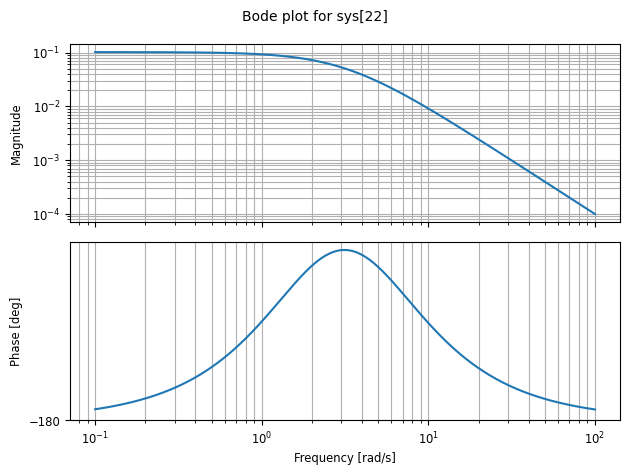

In [19]:
# Define the system dynamics
def inverted_pendulum_update(t, x, u, params={}):
    g = 9.81  # Acceleration due to gravity in m/s^2
    L = 1.0   # Length of the pendulum in meters
    b = 0.1   # Damping coefficient

    theta, theta_dot = x  # Unpack the state variables
    theta += np.pi        # Shift the angle to make the upright position the zero point
    u = u[0]              # Control input (torque)

    # Equation of motion
    theta_ddot = (u - b * theta_dot - g * np.sin(theta)) / L

    return np.array([theta_dot, theta_ddot])

def inverted_pendulum_output(t, x, u, params={}):
    return x[0]  # Output is the angle theta

# Create a NonlinearIOSystem for the pendulum
pendulum_nl = ct.NonlinearIOSystem(
    inverted_pendulum_update,  # Update function
    inverted_pendulum_output,  # Output function
    inputs=('u'),                       # Number of inputs
    outputs=('theta'),                  # Number of outputs
    states=('theta', 'theta_dot'),      # Number of states
    name='pendulum'
)

# Linearize the system around the upright position (theta = 0, theta_dot = 0) with zero input
x0 = [0, 0]  # Operating point (state)
u0 = [0]     # Operating point (input)
t0 = 0       # Time to linearize (usually 0 for time-invariant systems)

# Linearize the nonlinear system at the specified operating point
sys_lin = ct.linearize(pendulum_nl, xeq=x0, ueq=u0, t=t0)

# Convert the linearized state-space model to a transfer function
pendulum_tf = ct.ss2tf(sys_lin)
print("Transfer function of the linearized pendulum:")
print(pendulum_tf)

P_s = pendulum_tf

# Plot the singular value plot for the linearized system
plt.figure()
ct.bode_plot(pendulum_tf)
plt.show()

In [20]:
import control as ct
import numpy as np
import matplotlib.pyplot as plt

def makeweight_1(M : float, w1 : float) -> ct.TransferFunction:
    """
    Creates a frequency weight transfer function that has:
    - magnitude M >> 1 at low frequencies,
    - rolls off to zero at high frequencies,
    - and has magnitude 1 at the frequency s=j*w1.

    Parameters
    ----------
    - M (float): The desired DC gain of the transfer function.
    - w1 (float): The frequency at which the magnitude of the transfer function is 1.

    Returns
    -------
    TransferFunction: The frequency weight transfer function.

    """
    return ct.TransferFunction([M], [M/w1, 1])


def makeweight_3(M: float, w3 : float) -> ct.TransferFunction:
    """
    Creates a frequency weight transfer function that has:
    - zero DC gain,
    - approaches M >> 1 at high frequencies,
    - and has magnitude 1 at the frequency s=j*w3.

    Parameters
    ----------
    - M (float): The magnitude of the frequency weighting
    - w3: The frequency at which the weighting starts to take effect

    Returns
    -------
    - tf: The transfer function representing the frequency-weighted system
    """

    return ct.TransferFunction([M, 0], [1, M*w3])



def create_weight(wc, low_gain, high_gain):
    """
    Create a weighting function.
    
    Parameters:
    wc : float
        Crossover frequency (where the gain changes).
    low_gain : float
        Gain at low frequencies.
    high_gain : float
        Gain at high frequencies.
    """
    # Magnitude at crossover = geometric mean of low_gain and high_gain
    magnitude_at_wc = np.sqrt(low_gain * high_gain)

    # First order weight transfer function: (low_gain/s) / (1 + s/wc)
    num = [low_gain, 0]
    den = [1/wc, 1]

    return ct.TransferFunction(num, den)

# # Example parameters
# wc = 10  # Crossover frequency at 10 rad/s
# low_gain = 10  # High gain at low frequencies
# high_gain = 1  # Low gain at high frequencies

# weight_tf = create_weight(wc, low_gain, high_gain)

# # Plot the magnitude response
# omega = np.logspace(-1, 2, 500)
# mag, phase, omega = ct.bode(weight_tf, omega, plot=True)

# plt.figure()
# plt.semilogx(omega, 20 * np.log10(mag))
# plt.title('Weighting Function Magnitude Response')
# plt.xlabel('Frequency (rad/s)')
# plt.ylabel('Magnitude (dB)')
# plt.grid(True)
# plt.show()


# Task 1: Modern Control Synthesis

For modern control synthesis aproaches we need to define weights that we apply to our performance outputs.

![Block Diagram](images/blockdiagram.png)


given the transferfunctions L(s), S(s) and T(s), we want to ensure reference tracking and noise attenuation. This can be achieved by seeting up frequency weights for z_1 and z_3.

Remember how we defined $W_1(s)$ and $W_3(s)$ in the lecture:
- $||W_1(s)S(s)|| << 1$ or $\sigma_{min}[L(s)] >> |W_1(s)|$
- $||W_3(s)T(s)|| <<$ 1 or $\sigma_{max}[L(s)] << \frac{1}{|W_3(s)|}$

first we will define a python function that lets us create our frequency weights (spefifiying W = makeweight(dcgain,[freq,mag],hfgain))

then we will use the function to create our weights W_1(s) and W_3(s) and look at the singular values plots.

After that we will augment our plant with these weights and use a H2 design to desin a controller.

## Plant definition

The plant use in this task models the linearized behavior of a simple inverted pendulum an is given as $$P(s) = \frac{1}{s^2+0.1s-9.81}.$$
Note that this plant is unstable and we will need use a controller.

Initially we define our controller $C(s)$ to do nothing, i.e. $$C(s) = 1.$$


In [28]:
P_s = ct.TransferFunction([1], [1, 0.1, -9.81], input='u', output='y', name='P(s)')
C_s = ct.TransferFunction([1], [1], input='e', output='u', name='C(s)')

print("Plant transfer function:")
print(P_s)
print("\nController transfer function:")
print(C_s)

Plant transfer function:
<TransferFunction>: P(s)
Inputs (1): ['u']
Outputs (1): ['y']


        1
------------------
s^2 + 0.1 s - 9.81


Controller transfer function:
<TransferFunction>: C(s)
Inputs (1): ['e']
Outputs (1): ['u']


1
-
1



## Frequency Weights
We want to create the two weights $W_1(s)$ and $W_3(s)$ to ensure reference tracking and noise attenuation.

Remember how we defined $W_1(s)$ and $W_3(s)$ in the lecture:
- $||W_1(s)S(s)|| << 1$ or $\sigma_{min}[L(s)] >> |W_1(s)|$
- $||W_3(s)T(s)|| <<$ 1 or $\sigma_{max}[L(s)] << \frac{1}{|W_3(s)|}$

Therefore we want $W_1(s)$ to have very large magnitudes at flow frequencies and $W_3(s)$ to have large magnitudes at high frequencies.

You first task is to implement functions that create our frequency weights with the definition from Lecutre 9:

$$ W_1(s) = \frac{M}{Ms/\omega_1 + 1} \quad \text{and} \quad W_3(s) = \frac{Ms}{s + M\omega_3}.



In [22]:
def makeweight_1(M : float, w1 : float) -> ct.TransferFunction:
    """
    Creates a frequency weight transfer function that has:
    - magnitude M >> 1 at low frequencies,
    - rolls off to zero at high frequencies,
    - and has magnitude 1 at the frequency s=j*w1.

    Parameters
    ----------
    - M (float): The desired DC gain of the transfer function.
    - w1 (float): The frequency at which the magnitude of the transfer function is 1.

    Returns
    -------
    TransferFunction: The frequency weight transfer function.

    """
    return ct.TransferFunction([1], [1], name='W_1')


def makeweight_3(M: float, w3 : float) -> ct.TransferFunction:
    """
    Creates a frequency weight transfer function that has:
    - zero DC gain,
    - approaches M >> 1 at high frequencies,
    - and has magnitude 1 at the frequency s=j*w3.

    Parameters
    ----------
    - M (float): The magnitude of the frequency weighting
    - w3: The frequency at which the weighting starts to take effect

    Returns
    -------
    - tf: The transfer function representing the frequency-weighted system
    """

    return ct.TransferFunction([1], [1], name='W_3')

Solutions

In [5]:
# Solutions
def solution_makeweight_1(M : float, w1 : float) -> ct.TransferFunction:
    """
    Creates a frequency weight transfer function that has:
    - magnitude M >> 1 at low frequencies,
    - rolls off to zero at high frequencies,
    - and has magnitude 1 at the frequency s=j*w1.

    Parameters
    ----------
    - M (float): The desired DC gain of the transfer function.
    - w1 (float): The frequency at which the magnitude of the transfer function is 1.

    Returns
    -------
    TransferFunction: The frequency weight transfer function.

    """
    return ct.TransferFunction([M], [M/w1, 1], name='W_1')


def solution_makeweight_3(M: float, w3 : float) -> ct.TransferFunction:
    """
    Creates a frequency weight transfer function that has:
    - zero DC gain,
    - approaches M >> 1 at high frequencies,
    - and has magnitude 1 at the frequency s=j*w3.

    Parameters
    ----------
    - M (float): The magnitude of the frequency weighting
    - w3: The frequency at which the weighting starts to take effect

    Returns
    -------
    - tf: The transfer function representing the frequency-weighted system
    """

    return ct.TransferFunction([M, 0], [1, M*w3], name='W_3')

Now define the two weights such that:

- $W_1(s)$ has magnitude 100 at low frequencies, rolls off to zero at high frequency, and has magnitude 1 at frequency $\omega_1 = 0.1 \text{rad/s}$,
- $W_3(s)$ approaches magnitude 100 at high frequencies, has magnitude 1 at frequency $\omega_3 = 10\text{rad/s}$ and a zero DC gain.

In [109]:
W_1 = None
W_3 = None


# Solutions
solution_W_1 = solution_makeweight_1(100, 0.1)
solution_W_3 = solution_makeweight_3(100, 10)

# Test
assert W_1 == solution_W_1, "W_1 is incorrect"
assert W_3 == solution_W_3, "W_3 is incorrect"

AssertionError: W_1 is incorrect

## Visualization of Frequency weights

Now let us look at the singular value plots of these frequency weights and compare them to the open-loop transferfunction $L(s)$. Since we want $\sigma_{min}[L(s)] >> |W_1(s)|$ and $\sigma_{max}[L(s)] << \frac{1}{|W_3(s)|}$ We invert the $W_3(s)$

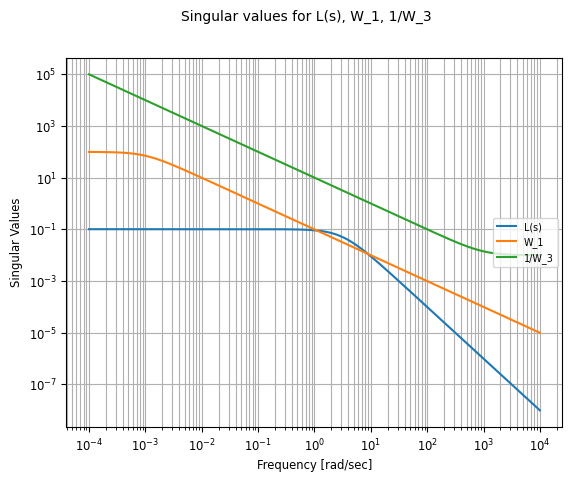

In [119]:
L_s = P_s * C_s
L_s.name = 'L(s)'

W_3_inverted = 1 / solution_W_3
W_3_inverted.name = '1/W_3'

_ = ct.singular_values_plot([L_s, solution_W_1, W_3_inverted])

We want the open loop transfer function $L(s)$ to lie in between the upper and lower bound given by $W_1(s)$ and $W_3(s)$ respectively. Note that we are dealing with a SISO system and therefore get only one singular value implying $\sigma_{min}[L(s)] = \sigma_{max}[L(s)]$.

This loop shaping problem boils down to finding a controller $C(s)$ that places $L(s)$ in between our obstacles $W_1(s)$ and $W_3(s)$. We want to find the generalized plant 
$$ G(s) = \begin{bmatrix} G_{zw}(s) & G_{zu}(s) \\ G_{yw}(s) & G_{yu}(s) \end{bmatrix},$$

which we can then use in a optimization problem to synthesize our controller C(s).

One could derive each transfer function by hand and would find that

$$ G(s) = \begin{bmatrix} W_1(s) & -W_1(s)P(s) \\ 0 & W_3(s)P(s) \end{bmatrix},$$

or we can use the function `ct.augw(g, w1, w2, w3)` from the `control` library. \
**Caution:** due to a different nomenclature `g` corresponds to the plant $P(s)$ and **NOT** the generalized plant $G(s)$!


In [156]:
W2 = ct.tf([0.1], [1])
G_s = ct.augw(P_s, w1=solution_W_1, w2=W2, w3=solution_W_3)

display(G_s)

StateSpace(array([[-1.00e-03,  0.00e+00,  0.00e+00,  1.00e-01],
       [ 0.00e+00, -1.00e+03,  0.00e+00, -1.00e+01],
       [ 0.00e+00,  0.00e+00, -1.00e-01,  9.81e-01],
       [ 0.00e+00,  0.00e+00,  1.00e+01,  0.00e+00]]), array([[ 1.,  0.],
       [ 0.,  0.],
       [ 0., -1.],
       [ 0.,  0.]]), array([[ 1.e-01,  0.e+00,  0.e+00,  0.e+00],
       [ 0.e+00,  0.e+00,  0.e+00,  0.e+00],
       [ 0.e+00, -1.e+03,  0.e+00, -1.e+01],
       [ 0.e+00,  0.e+00,  0.e+00,  1.e-01]]), array([[0. , 0. ],
       [0. , 0.1],
       [0. , 0. ],
       [1. , 0. ]]))

Now we can use e.g. $H_2$ optimal control to find our controller. 

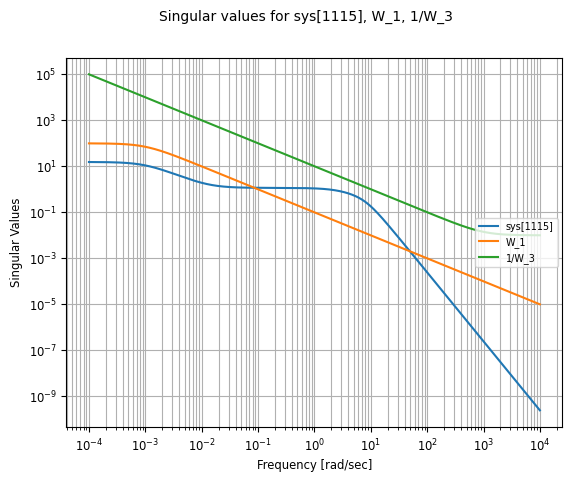

In [166]:
C_s = ct.h2syn(G_s, nmeas=1, ncon=1)
T = ct.feedback(P_s*C_s, sign=1)

L_s = P_s * C_s

_ = ct.singular_values_plot([L_s, solution_W_1, W_3_inverted])

array([[list([<matplotlib.lines.Line2D object at 0x000002376011D000>, <matplotlib.lines.Line2D object at 0x000002376011ECE0>, <matplotlib.lines.Line2D object at 0x000002376011F220>])],
       [list([<matplotlib.lines.Line2D object at 0x000002376011EB30>, <matplotlib.lines.Line2D object at 0x000002376011EF50>, <matplotlib.lines.Line2D object at 0x000002376011F490>])]],
      dtype=object)

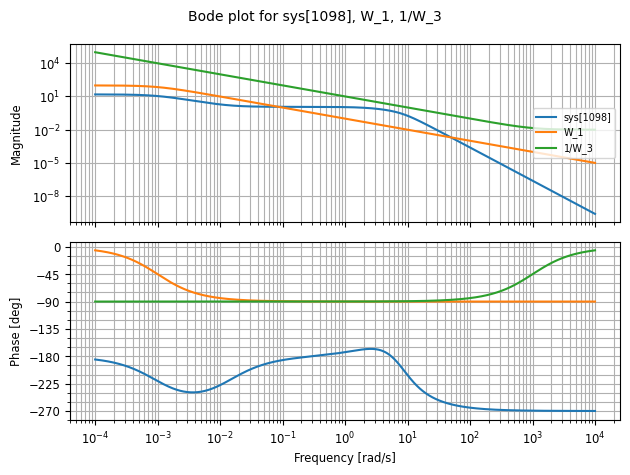

In [163]:
ct.bode([L_s, solution_W_1, W_3_inverted])

In [146]:
P = ct.tf([1], [1, 2, 1])
P_ss = ct.tf2ss(P)
P_ss


StateSpace(array([[-2., -1.],
       [ 1.,  0.]]), array([[-1.],
       [ 0.]]), array([[ 0., -1.]]), array([[0.]]))

In [147]:
# Performance weight
W1 = ct.tf([1, 0.5], [0.5, 1])

# Sensor noise weight
W2 = ct.tf([0.1], [1])

# Control effort weight
W3 = ct.tf([0.01], [1, 0.01])

In [150]:
# Construct the augmented plant
P_aug = ct.augw(P, W1, W2, W3)

display(P_aug)

StateSpace(array([[-2.  ,  0.  ,  0.  ,  1.  ],
       [ 0.  , -0.01,  0.  , -0.1 ],
       [ 0.  ,  0.  , -2.  , -1.  ],
       [ 0.  ,  0.  ,  1.  ,  0.  ]]), array([[ 1.,  0.],
       [ 0.,  0.],
       [ 0., -1.],
       [ 0.,  0.]]), array([[-3. ,  0. ,  0. ,  2. ],
       [ 0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0.1,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  1. ]]), array([[2. , 0. ],
       [0. , 0.1],
       [0. , 0. ],
       [1. , 0. ]]))

In [153]:
# Synthesize H2 optimal controller
K = ct.h2syn(P_aug, 1, 1)
display(K)

StateSpace(array([[-2.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00, -1.00000000e-02,  0.00000000e+00,
        -1.00000000e-01],
       [ 1.57609007e+01,  6.01805661e-01, -5.30798755e+00,
        -1.30873659e+01],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00]]), array([[ 1.00000000e+00],
       [-1.93837389e-17],
       [-7.85046229e-17],
       [ 0.00000000e+00]]), array([[-15.76090073,  -0.60180566,   3.30798755,  12.08736591]]), array([[0.]]))

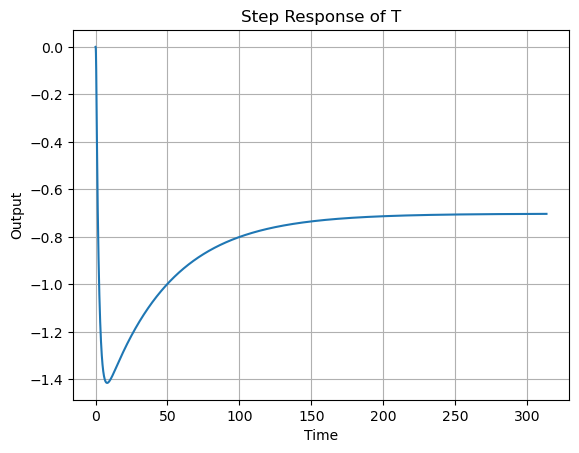

Text(0.5, 1.0, 'Controller Bode Plot')

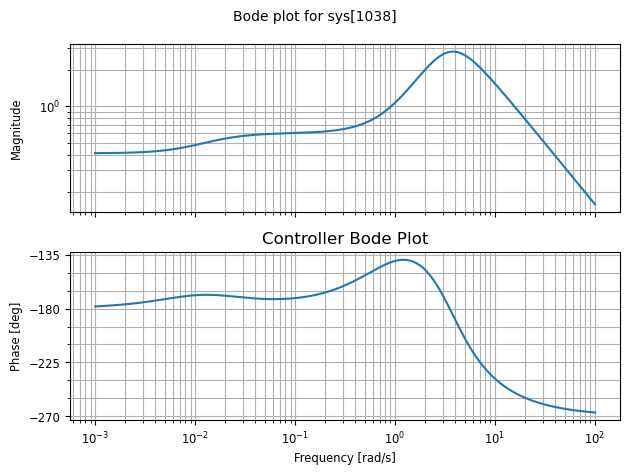

In [155]:
import numpy as np
import control
# Closed-loop system from reference to output
T = ct.feedback(K*P, 1);

# Step response of the closed-loop system
plt.figure()

# Compute the step response
t, y = control.step_response(T)

# Plot the step response
plt.plot(t, y)
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('Step Response of T')
plt.grid(True)
plt.show()

# Bode plot of the controller
plt.figure
ct.bode(K)
plt.title('Controller Bode Plot')


Open-loop transfer function: 
        1
------------------
s^2 + 0.1 s - 9.81



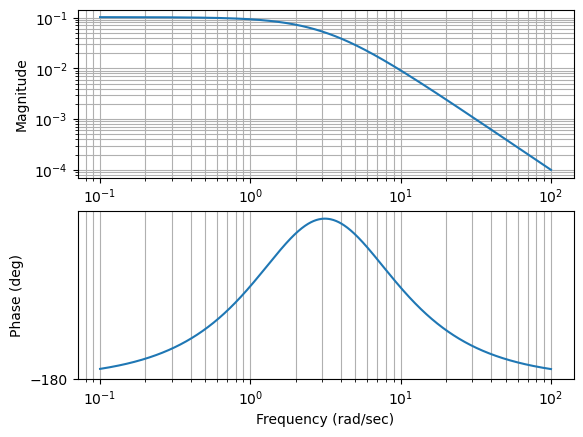

In [206]:
L_s = C_s * P_s
print("Open-loop transfer function:", L_s)

_ = ct.bode(L_s)

TransferFunction(array([10]), array([10.,  1.]))

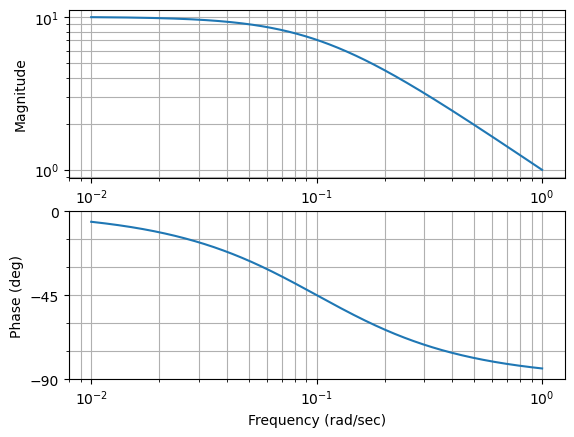

In [190]:
weight_tf = create_weight(wc=1, low_gain=0, high_gain=10)
W_1 = makeweight_1(dcgain=10, freq=1, mag=1, hfgain=0)
ct.bode_plot(W_1)
W_1


In [176]:
augmented_plant_ss = ct.augw(P_s, w1=weig1ht_tf, w2=None, w3=None)
augmented_plant_ss


TypeError: ss(sys): sys must be a StateSpace or TransferFunction object.  It is <class 'int'>.

In [173]:
augmented_plant_tf = ct.ss2tf(augmented_plant_ss)
augmented_plant_tf

TransferFunction([[array([ 100.        ,   10.        , -981.00000014,    0.        ]), array([-1.00000000e+02, -1.38777878e-15])], [array([ 1.  ,  0.1 , -9.81,  0.  ]), array([-1.,  0.])]], [[array([  1.        ,  10.1       ,  -8.81      , -98.10000001]), array([  1.        ,  10.1       ,  -8.81      , -98.10000001])], [array([ 1.  ,  0.1 , -9.81,  0.  ]), array([ 1.  ,  0.1 , -9.81,  0.  ])]])

In [175]:
sys_lin

<LinearIOSystem:sys[443]:['u[0]']->['y[0]']>

## Create Weighting function

W = makeweight(dcgain,[freq,mag],hfgain)

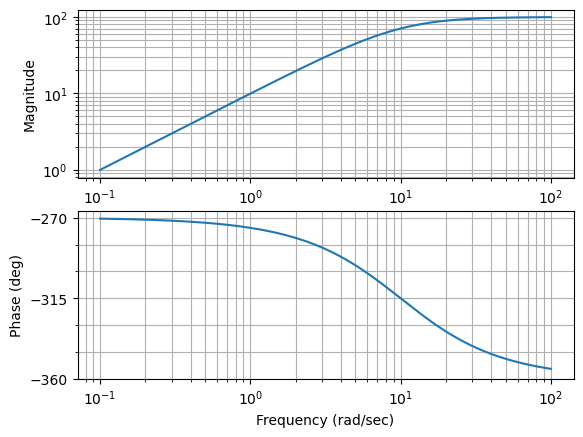

In [162]:
import control as ct
import numpy as np
import matplotlib.pyplot as plt

def makeweight_1(dcgain, freq,mag ,hfgain):
    
    return ct.TransferFunction([dcgain], [1/freq, 1])


def makeweight_3(dcgain, freq, mag, hfgain):
    
    return ct.TransferFunction([hfgain, 0], [1, hfgain*freq])



def create_weight(wc, low_gain, high_gain):
    """
    Create a weighting function.
    
    Parameters:
    wc : float
        Crossover frequency (where the gain changes).
    low_gain : float
        Gain at low frequencies.
    high_gain : float
        Gain at high frequencies.
    """
    # Magnitude at crossover = geometric mean of low_gain and high_gain
    magnitude_at_wc = np.sqrt(low_gain * high_gain)

    # First order weight transfer function: (low_gain/s) / (1 + s/wc)
    num = [low_gain, 0]
    den = [1/wc, 1]

    return ct.TransferFunction(num, den)

# Example parameters
wc = 10  # Crossover frequency at 10 rad/s
low_gain = 10  # High gain at low frequencies
high_gain = 1  # Low gain at high frequencies

weight_tf = create_weight(wc, low_gain, high_gain)

# Plot the magnitude response
omega = np.logspace(-1, 2, 500)
mag, phase, omega = ct.bode(weight_tf, omega, plot=True)

# plt.figure()
# plt.semilogx(omega, 20 * np.log10(mag))
# plt.title('Weighting Function Magnitude Response')
# plt.xlabel('Frequency (rad/s)')
# plt.ylabel('Magnitude (dB)')
# plt.grid(True)
# plt.show()


# Testing

Transfer function of the linearized pendulum:

        1
------------------
s^2 + 0.1 s - 9.81



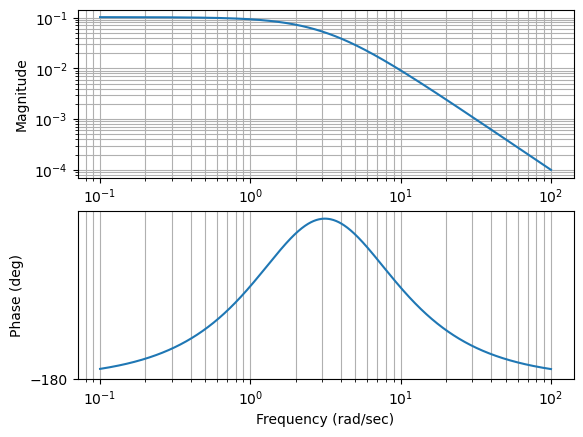

In [54]:
import control as ct
import numpy as np
import matplotlib.pyplot as plt

# Define the system dynamics
def inverted_pendulum_update(t, x, u, params={}):
    g = 9.81  # Acceleration due to gravity in m/s^2
    L = 1.0   # Length of the pendulum in meters
    b = 0.1   # Damping coefficient

    theta, theta_dot = x  # Unpack the state variables
    theta += np.pi        # Shift the angle to make the upright position the zero point
    u = u[0]              # Control input (torque)

    # Equation of motion
    theta_ddot = (u - b * theta_dot - g * np.sin(theta)) / L

    return np.array([theta_dot, theta_ddot])

def inverted_pendulum_output(t, x, u, params={}):
    return x[0]  # Output is the angle theta

# Create a NonlinearIOSystem for the pendulum
pendulum_nl = ct.NonlinearIOSystem(
    inverted_pendulum_update,  # Update function
    inverted_pendulum_output,  # Output function
    inputs=('u'),                       # Number of inputs
    outputs=('theta'),                  # Number of outputs
    states=('theta', 'theta_dot'),      # Number of states
    name='pendulum'
)

# Linearize the system around the upright position (theta = 0, theta_dot = 0) with zero input
x0 = [0, 0]  # Operating point (state)
u0 = [0]     # Operating point (input)
t0 = 0       # Time to linearize (usually 0 for time-invariant systems)

# Linearize the nonlinear system at the specified operating point
sys_lin = ct.linearize(pendulum_nl, xeq=x0, ueq=u0, t=t0)

# Convert the linearized state-space model to a transfer function
pendulum_tf = ct.ss2tf(sys_lin)
print("Transfer function of the linearized pendulum:")
print(pendulum_tf)

P_s = pendulum_tf

# Plot the singular value plot for the linearized system
plt.figure()
ct.bode_plot(pendulum_tf)
plt.show()

In [55]:
# Assume P_s is the transfer function you obtained earlier
poles = ct.pole(pendulum_tf)

# Check if all poles have negative real parts
is_stable = all(p.real < 0 for p in poles)

print("System is stable:" if is_stable else "System is unstable:")
print(poles)

System is unstable:
[-3.18249102+0.j  3.08249102+0.j]


In [56]:
sys_lin

<LinearIOSystem:sys[31]:['u[0]']->['y[0]']>

In [57]:
A = sys_lin.A

D, V = np.linalg.eig(A)
D

array([ 3.08249102, -3.18249102])

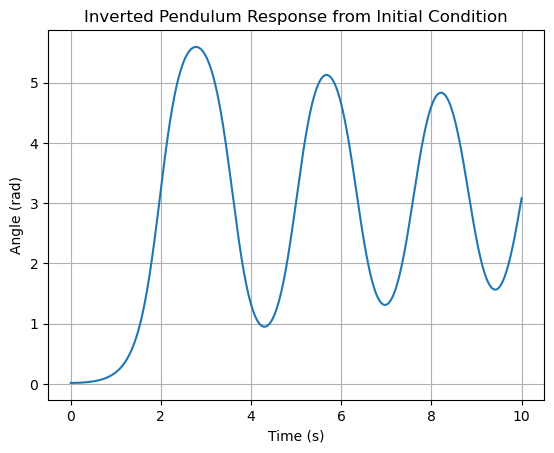

In [59]:
# Initial conditions: small angle (e.g., 5 degrees converted to radians)
theta_initial = np.deg2rad(1)  # Initial angle 
theta_dot_initial = 0          # Initial angular velocity
x0 = [theta_initial, theta_dot_initial]

# Time vector for the simulation
t = np.linspace(0, 10, 1000)  # Simulate for 10 seconds

# Zero input (no control input)
u = np.zeros_like(t)

# Simulate the response
t, y = ct.input_output_response(pendulum_nl, T=t, U=u, X0=x0)

# Plotting the response
plt.figure()
plt.plot(t, y)
plt.title('Inverted Pendulum Response from Initial Condition')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.grid(True)
plt.show()

In [60]:
theta_initial

0.017453292519943295

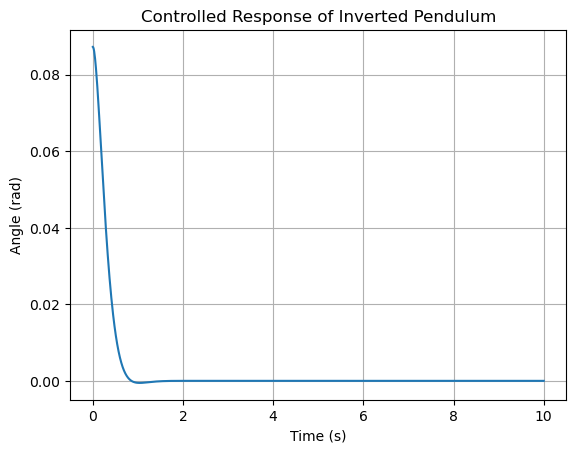

In [151]:
import control as ct
import numpy as np
import matplotlib.pyplot as plt

# Assume sys_lin is the linearized state-space model from previous steps
# Linearizing again for clarity in this context
# Define operating points and system parameters as before

# Define weight matrices for LQR
Q = np.diag([100, 1])  # State weight matrix
R = [0.1]              # Input weight matrix

# Compute the LQR controller gain
K, _, _ = ct.lqr(sys_lin.A, sys_lin.B, Q, R)

# Create the closed-loop system (A-BK)
A_cl = sys_lin.A - sys_lin.B @ K
B_cl = sys_lin.B
C_cl = sys_lin.C
D_cl = sys_lin.D

sys_cl = ct.StateSpace(A_cl, B_cl, C_cl, D_cl)

# Initial conditions and simulation parameters
theta_initial = 5 * np.pi / 180  # 5 degrees in radians
theta_dot_initial = 0
x0_cl = [theta_initial, theta_dot_initial]

# Simulate the response
t = np.linspace(0, 10, 1000)
t, y_cl = ct.initial_response(sys_cl, T=t, X0=x0_cl)

# Plotting the controlled response
plt.figure()
plt.plot(t, y_cl)
plt.title('Controlled Response of Inverted Pendulum')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.grid(True)
plt.show()


In [63]:
T_s = ct.ss2tf(sys_cl)
print(T_s)


         1
--------------------
s^2 + 9.79 s + 33.11



In [64]:
# Assume P_s is the transfer function you obtained earlier
poles = ct.pole(T_s)

# Check if all poles have negative real parts
is_stable = all(p.real < 0 for p in poles)

print("System is stable:" if is_stable else "System is unstable:")
print(poles)

System is stable:
[-4.8951229+3.02443849j -4.8951229-3.02443849j]


# LGR LQR

In [155]:
import numpy as np
import control as ct
import matplotlib.pyplot as plt

# System matrices (assuming you have already a linearized model sys_lin)
A = sys_lin.A
B = sys_lin.B
C = sys_lin.C
D = sys_lin.D

Q = np.diag([100, 1])  # State weight matrix
R = [0.1]              # Input weight matrix

# Design state feedback controller (LQR)
K, S, E = ct.lqr(sys_lin, Q, R)

# Define LQE noise covariances
Qe = np.diag([0.1, 0.1])  # Process noise covariance
Re = np.diag([0.1])  # Measurement noise covariance

# Design observer (LQE)
L, P, E = ct.lqe(sys=sys_lin, QN=Qe, RN=Re)  

# Implement the observer
A_obs = A - L @ C
B_obs = np.hstack([B, L])
C_obs = np.eye(A.shape[0])  # Identity matrix for full state output
D_obs = np.zeros((A.shape[0], B_obs.shape[1]))

observer_ss = ct.StateSpace(A_obs, B_obs, C_obs, D_obs)

# Closed-loop system matrices
A_cl = A - B @ K
B_cl = B.copy()  # For input or external disturbance
C_cl = C.copy()
D_cl = D.copy()

# Combine into one system (assuming direct state measurement for simplicity)
sys_cl = ct.StateSpace(A_cl, B_cl, C_cl, D_cl)

# Simulate the system
t = np.linspace(0, 10, 1000)
x0 = np.array([0.1, 0, 0, 0])  # Initial condition for the states
t, y = ct.initial_response(sys_cl, T=t, X0=x0)

# Plotting the response
plt.figure()
plt.plot(t, y)
plt.title('Response of the Inverted Pendulum with LQR and Luenberger Observer')
plt.xlabel('Time (s)')
plt.ylabel('State response')
plt.grid(True)
plt.show()


IndexError: tuple index out of range

# PI Controller

PID Controller Transfer Function:

10 s^2 + 50 s + 5
-----------------
        s

Plant Transfer Function:

        1
------------------
s^2 + 0.1 s - 9.81

Open-loop Transfer Function:

  10 s^2 + 50 s + 5
----------------------
s^3 + 0.1 s^2 - 9.81 s

Closed-loop Transfer Function:

     10 s^2 + 50 s + 5
----------------------------
s^3 + 10.1 s^2 + 40.19 s + 5



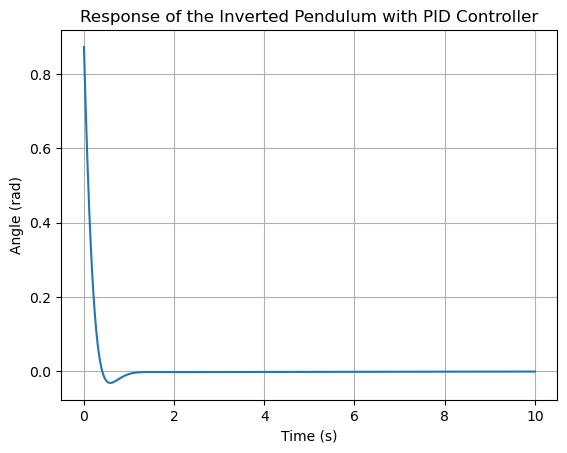

In [149]:
import control as ct
import numpy as np
import matplotlib.pyplot as plt

# Define the PID parameters
Kp = 50.0  # Proportional gain
Ki = 5.0   # Integral gain
Kd = 10  # Derivative gain

# Create the PID controller transfer function
num = [Kd, Kp, Ki]  # Coefficients of s^2, s, and constant
den = [1, 0]        # Coefficient for s in the denominator makes it proper
C_s = ct.TransferFunction(num, den)

print("PID Controller Transfer Function:")
print(C_s)

print("Plant Transfer Function:")
print(pendulum_tf)

# Assume sys_lin is your plant model obtained by linearizing the nonlinear system
# Combine the controller and the plant in a feedback loop
system_open_loop = C_s * pendulum_tf
print("Open-loop Transfer Function:")
print(system_open_loop)

system_closed_loop = ct.feedback(system_open_loop, 1)
print("Closed-loop Transfer Function:")
print(system_closed_loop)

# Simulate the response to an initial condition
t = np.linspace(0, 10, 1000)
initial_condition = [np.deg2rad(5), 0, 0]  # Starting with a small angle deviation, the third argument is the initial error
t, y = ct.initial_response(system_closed_loop, T=t, X0=initial_condition)

# Plotting the response
plt.figure()
plt.plot(t, y)
plt.title('Response of the Inverted Pendulum with PID Controller')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.grid(True)
plt.show()


In [145]:
print(system_closed_loop)


     10 s^2 + 50 s + 5
----------------------------
s^3 + 10.1 s^2 + 40.19 s + 5



In [146]:
# Assume P_s is the transfer function you obtained earlier
poles = ct.pole(system_closed_loop)

# Check if all poles have negative real parts
is_stable = all(p.real < 0 for p in poles)

print("System is stable:" if is_stable else "System is unstable:")
print(poles)

System is stable:
[-4.98574685+3.74845683j -4.98574685-3.74845683j -0.12850629+0.j        ]
